<a href="https://colab.research.google.com/github/diya-nagchaudhury/dlsc-projects/blob/main/CASML_2024_Day2_Hands_on_Neural_Operators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Neural Operators (FNO)

### In this tutorial, we will:

- **Introduce the theoretical foundation** of Fourier Neural Operators and their connection to spectral methods.  
- **Implement a classical example** from the original paper by Li et al., where an FNO is trained to solve the 1D Burgers' equation.  
- **Discuss training strategies, architectural choices, and evaluation metrics** to benchmark the model’s performance.  


## Neural Operators

Neural Operators are mappings across discretized function spaces. They serve multiple purposes:

* Mapping from an initial condition to the solution function at a later temporal point (or to the entire spatiotemporal solution function)
* Creating autoregressive timesteppers that transition state $u^{[t]}_h$ to state $u_h^{[t+1]}$

Fourier Neural Operators leverage the Fast Fourier Transform (FFT) to conduct efficient **spectral convolution** while capturing global features. They represent a multiscale architectural approach.

For comprehensive insights into FNO, the original research paper provides detailed explanations.

Neural Operators facilitate solving entire parametric families of Partial Differential Equations.
FNOs notably enable **zero-shot superresolution**.

### Spectral Convolutions

Given the (real-valued) input discretized state $a$ (potentially multi-channeled) defined on an equidistant mesh, follow these steps:

1. Transform $a$ into Fourier space (using real-valued Fourier transform): $\hat{a} = \text{rfft}(a)$ (batch over the channel dimension)
2. Execute a batched matrix multiplication with a complex-valued weight vector $W$ for the initial $K$ modes: $\hat{\tilde{a}}_{0:K} = W\hat{a}_{0:K}$
3. Zero out remaining modes $\hat{\tilde{a}}_{K:} = 0 + 0i$
4. Transform back to real space $\tilde{a} = \text{irfft}(\hat{\tilde{a}})$

Each spectral convolution's learnable parameters comprise a complex-valued weight matrix shaped (channels_out, channels_in, modes), effectively representing 2 * channels_out * channels_in * modes real parameters.

### Fourier Neural Operator

A standard FNO comprises a lifting layer, multiple "ResNet"-style spectral convolution blocks with bypass, and a projection layer. Projection and lifting layers utilize 1x1 Convolutions to modify channel dimensions. The blocks operate via $b = \text{activation}(\tilde{a} + \text{Conv}_{1\times1}(a))$.

We'll replicate an example from the original paper by [Li et al.] solving the **1d Burgers equation**:

$$ \frac{\partial u}{∂ t} + \frac{1}{2}\frac{\partial u^2}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

The periodic domain $\Omega = (0, 2 \pi)$ maintains the condition $u(t, x=0) = u(t, x=2 \pi)$ with a fixed diffusivity of $\nu=0.1$. Our dataset includes $2048$ initial conditions $u(t=0, x)$ at $N=8192$ resolution, accompanied by their one-time-step solution $u(t=1, x)$. The FNO aims to learn the mapping from initial condition to one-step state using supervised learning.

### Implementation Details

* Training utilizes a $32$-fold downsampled dataset (i.e., $256$ degrees of freedom instead of $8192$)
    * Training occurs on the first 1000 data points
    * Validation/Testing uses the subsequent 200 data points
* The FNO incorporates $16$ modes, $64$ hidden channels, and four stacked spectral convolution blocks with bypass
* Dataset reshuffling occurs each epoch with a batch size of $100$
* Training spans $200$ epochs
* Adam optimizer with default settings and a fixed learning rate of 3e-4 is employed

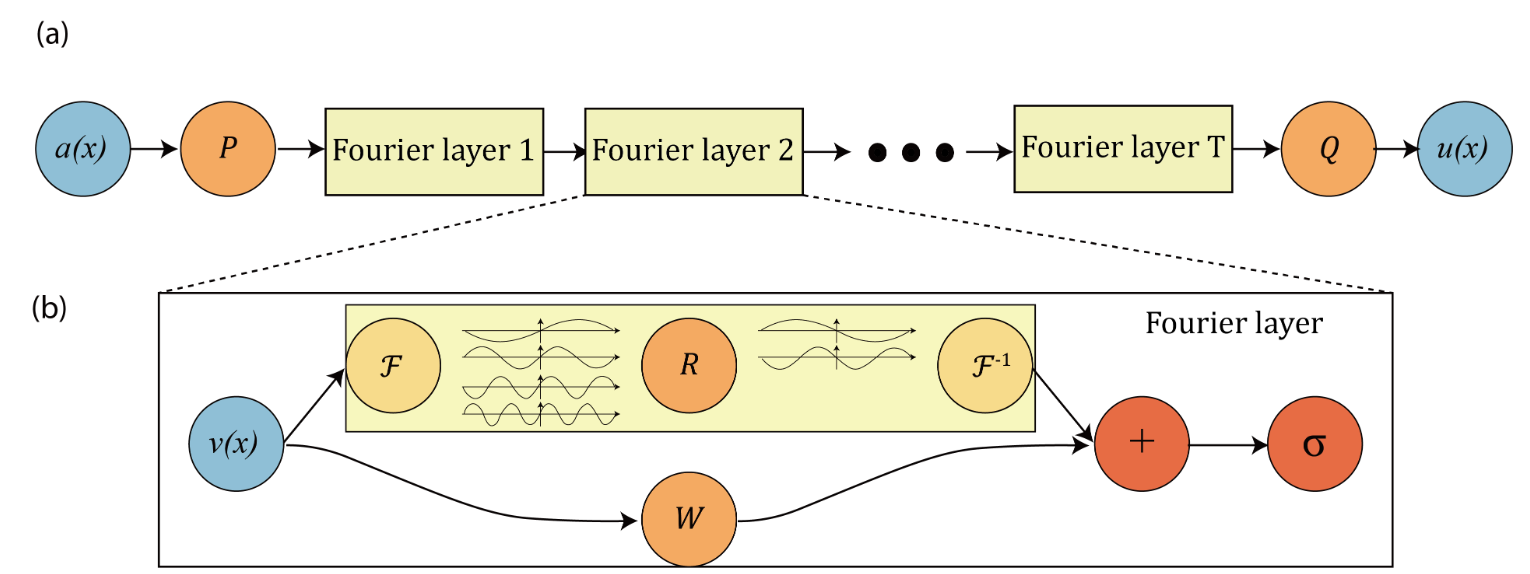

In [2]:
%pip install equinox

In [3]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy

from tqdm.autonotebook import tqdm

<ipython-input-3-8ceb1e6957f4>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# Mathworks (the creators of Matlab) host the original Li et al. dataset in the .mat format
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2024-12-14 23:26:50--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.76.59.204
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.76.59.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  77.9MB/s    in 9.9s    

2024-12-14 23:27:00 (61.8 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [5]:
data = scipy.io.loadmat("burgers_data_R10.mat")

In [6]:
a, u = data["a"], data["u"]

In [7]:
a.shape, u.shape

((2048, 8192), (2048, 8192))

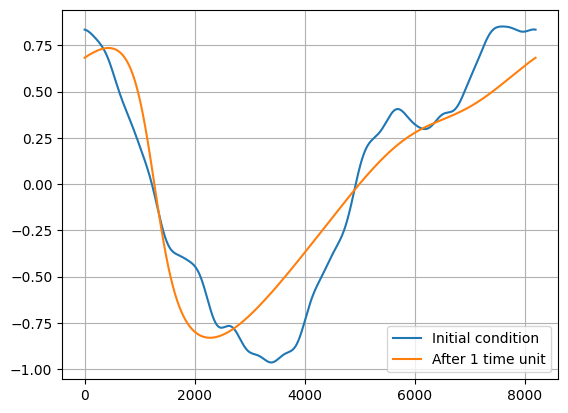

In [9]:
plt.plot(a[0], label="Initial condition")
plt.plot(u[0], label="After 1 time unit")
plt.legend()
plt.grid()

In [10]:
# Add channel dimension
a = a[:, jnp.newaxis, :]
u = u[:, jnp.newaxis, :]

In [11]:
# Mesh is from 0 to 2 pi
mesh = jnp.linspace(0, 2 * jnp.pi, u.shape[-1])

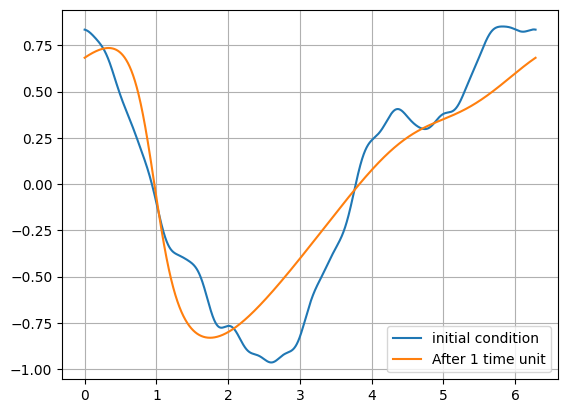

In [12]:
plt.plot(mesh, a[0, 0], label="initial condition")
plt.plot(mesh, u[0, 0], label="After 1 time unit")
plt.legend()
plt.grid()

In [13]:
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], u.shape[0], axis=0)
a_with_mesh = jnp.concatenate((a, mesh_shape_corrected), axis=1)

In [14]:
a_with_mesh.shape

(2048, 2, 8192)

In [15]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [31]:
class SpectralConv1d(eqx.Module):
    """
    Implements a 1D spectral convolution layer using Fourier transforms.

    This layer performs convolution in the frequency domain, leveraging the
    Fourier transform to capture global features in the input data. It is a
    key component of Fourier Neural Operators (FNO), which are designed to
    learn mappings between discretized function spaces.

    Attributes:
        real_weights (jax.Array): Real part of the complex-valued weights,
            shaped (in_channels, out_channels, modes).
        imag_weights (jax.Array): Imaginary part of the complex-valued weights,
            shaped (in_channels, out_channels, modes).
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes (int): Number of Fourier modes to retain.

    Methods:
        complex_mult1d(x_hat, w):
            Performs complex-valued matrix multiplication in the frequency domain.
        __call__(x):
            Applies the spectral convolution to the input tensor `x`.
    """

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key,
    ):
        """
        Initializes the SpectralConv1d layer with the given input and output
        channel dimensions, number of Fourier modes, and a random key.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            modes (int): Number of Fourier modes to retain in the spectral domain.
            key (jax.random.PRNGKey): JAX random key for initializing weights.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    def complex_mult1d(
            self,
            x_hat,
            w,
    ):
        """
        Performs complex-valued matrix multiplication in the frequency domain.

        Args:
            x_hat (jnp.ndarray): Input tensor in the frequency domain, shaped
                (in_channels, modes).
            w (jnp.ndarray): Complex-valued weight tensor, shaped
                (in_channels, out_channels, modes).

        Returns:
            jnp.ndarray: Output tensor in the frequency domain, shaped
                (out_channels, modes).
        """
        return jnp.einsum("iM,ioM->oM", x_hat, w)

    def __call__(
            self,
            x,
    ):
        """
        Applies the spectral convolution to the input tensor `x`.

        Args:
            x (jnp.ndarray): Input tensor in the spatial domain, shaped
                (in_channels, spatial_points).

        Returns:
            jnp.ndarray: Output tensor in the spatial domain, shaped
                (out_channels, spatial_points).
        """
        channels, spatial_points = x.shape

        # Compute Fourier transform of the input
        x_hat = jnp.fft.rfft(x)  # Shape: (in_channels, spatial_points//2+1)

        # Retain only the first `modes` Fourier modes
        x_hat_under_modes = x_hat[:, :self.modes]  # Shape: (in_channels, modes)

        # Create complex weights
        weights = self.real_weights + 1j * self.imag_weights

        # Perform complex matrix multiplication in Fourier space
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)  # Shape: (out_channels, modes)

        # Initialize the output in Fourier space
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )

        # Set the retained modes in the output
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        # Compute inverse Fourier transform to return to spatial domain
        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out


In [17]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            activation,
            *,
            key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )

In [32]:
class FNOBlock1d(eqx.Module):
    """
    Implements a single block of the 1D Fourier Neural Operator (FNO).

    This block combines a spectral convolution for capturing global patterns
    with a bypass convolution for localized adjustments. It also applies a
    non-linear activation function to the combined outputs, resembling a
    "ResNet"-like architecture.

    Attributes:
        spectral_conv (SpectralConv1d): Spectral convolution layer for capturing global features.
        bypass_conv (eqx.nn.Conv1d): 1x1 convolution layer for localized adjustments.
        activation (Callable): Non-linear activation function to apply after combining outputs.

    Methods:
        __call__(x):
            Applies the FNO block to the input tensor `x`.

    Usage:
        This block is a fundamental building unit of the Fourier Neural Operator
        and can be stacked to form deeper architectures.

    """

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            modes: int,
            activation: Callable,
            *,
            key,
    ):
        """
        Initializes the FNOBlock1d with spectral and bypass convolutions, as well
        as the activation function.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            modes (int): Number of Fourier modes to retain in the spectral convolution.
            activation (Callable): Activation function (e.g., ReLU, Tanh).
            key (jax.random.PRNGKey): JAX random key for initializing the layers.
        """
        spectral_conv_key, bypass_conv_key = jax.random.split(key)

        # Spectral convolution for global feature extraction
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )

        # 1x1 convolution for localized adjustments
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )

        # Non-linear activation function
        self.activation = activation

    def __call__(
            self,
            x: jax.Array,
    ) -> jax.Array:
        """
        Applies the FNO block to the input tensor `x`.

        Args:
            x (jax.Array): Input tensor of shape (in_channels, spatial_points).

        Returns:
            jax.Array: Output tensor of shape (out_channels, spatial_points).

        Workflow:
            1. Applies the spectral convolution to capture global features.
            2. Applies the bypass 1x1 convolution to adjust localized patterns.
            3. Combines the two outputs and applies the activation function.
        """
        # Combine outputs from spectral and bypass convolutions, then activate
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )


In [19]:
fno = FNO1d(
    2,
    1,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [20]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [ ]:
def loss_fn(model, x, y):
    """
    Computes the mean squared error (MSE) loss between the predicted and actual outputs.

    Args:
        model: The model to evaluate.
        x: Input data.
        y: Target data.

    Returns:
        jnp.ndarray: The computed loss value.
    """
    # Vectorized model predictions for the batch
    y_pred = jax.vmap(model)(x)
    # Mean squared error loss
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

# Initialize the Adam optimizer with a learning rate of 3e-4
optimizer = optax.adam(3e-4)

# Initialize optimizer state, filtering the model parameters for trainable arrays
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit
def make_step(model, state, x, y):
    """
    Performs a single optimization step.

    Args:
        model: The model being trained.
        state: The optimizer state.
        x: Input batch of data.
        y: Target batch of data.

    Returns:
        new_model: The updated model after applying the gradients.
        new_state: The updated optimizer state.
        loss: The training loss for the batch.
        val_loss: The validation loss.
    """
    # Compute the loss and its gradient with respect to the model parameters
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)

    # Compute validation loss using test data (downsampled)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])

    # Update the optimizer state and model parameters
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)

    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

# Initialize a PRNG key for shuffling the dataset
shuffle_key = jax.random.PRNGKey(10)

# Training loop for 200 epochs
for epoch in tqdm(range(200)):  # tqdm adds a progress bar
    # Generate a new random key for shuffling the dataset at each epoch
    shuffle_key, subkey = jax.random.split(shuffle_key)

    # Iterate over batches in the dataloader
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],  # Use downsampled training data
        train_y[..., ::32],
        batch_size=100,  # Process 100 samples per batch
    ):
        # Perform a single optimization step
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)

        # Record the training and validation losses
        loss_history.append(loss)
        val_loss_history.append(val_loss)


  0%|          | 0/200 [00:00<?, ?it/s]

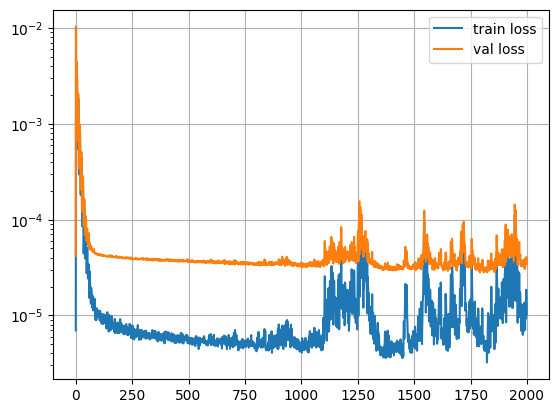

In [40]:
# Plot the training and validation loss histories
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

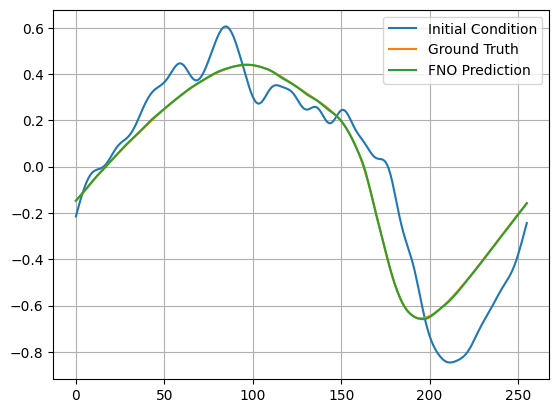

In [35]:
# Plot the initial condition (input to the FNO model)
plt.plot(test_x[1, 0, ::32], label="Initial Condition")

# Plot the ground truth (expected output at time t=1)
# plt.plot(test_y[1, 0, ::32], label="Ground Truth")

# Plot the FNO's predicted output at time t=1
plt.plot(fno(test_x[1, :, ::32])[0], label="FNO Prediction")
plt.legend()
plt.grid()

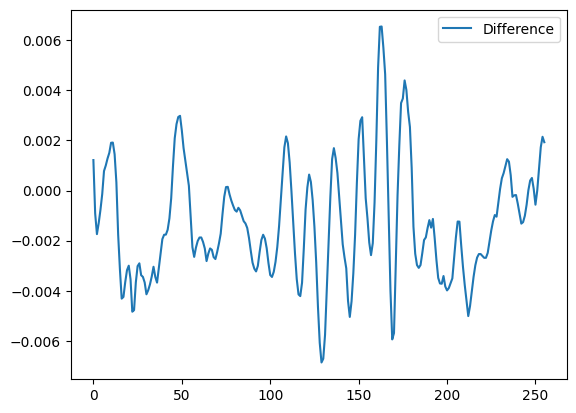

In [24]:
plt.plot(fno(test_x[1, :, ::32])[0] - test_y[1, 0, ::32], label="Difference")
plt.legend()

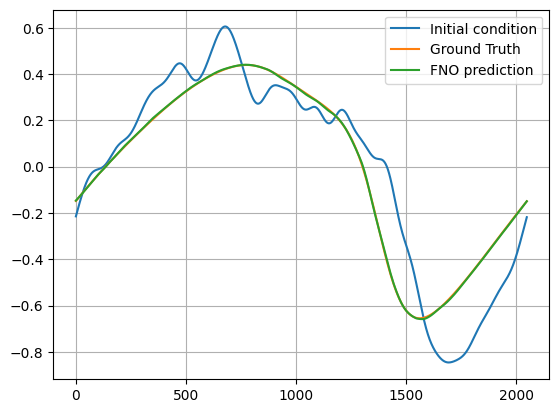

In [36]:
# Plot the initial condition (input to the model) at a lower resolution (downsampled by a factor of 4)
# This is the state of the system at time t=0
plt.plot(test_x[1, 0, ::4], label="Initial condition")

# Plot the ground truth (expected output at time t=1) at the same lower resolution
# This is the true solution of the system at time t=1
plt.plot(test_y[1, 0, ::4], label="Ground Truth")

# Plot the FNO's predicted output at time t=1, from the lower resolution input
# The FNO is performing zero-shot superresolution, attempting to predict the high-resolution state from the low-res input
plt.plot(fno(test_x[1, :, ::4])[0], label="FNO prediction")

# Add a legend to differentiate between the three curves (Initial condition, Ground truth, and FNO prediction)
plt.legend()

# Add a grid to the plot for easier visualization of data points
plt.grid()


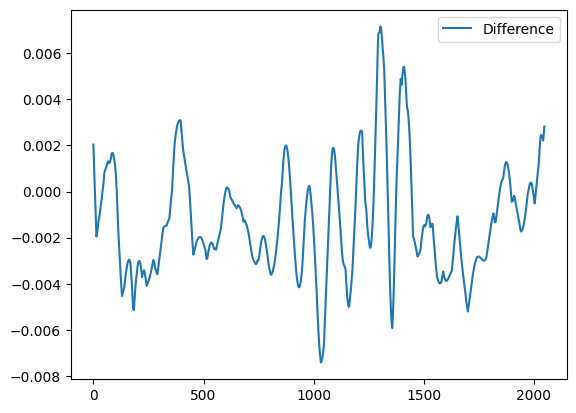

In [26]:
plt.plot(fno(test_x[1, :, ::4])[0] - test_y[1, 0, ::4], label="Difference")
plt.legend()

In [37]:
# Compute predictions for the entire test set using the FNO model
# `jax.vmap(fno)` applies the FNO model across the entire batch of test inputs `test_x`
test_pred = jax.vmap(fno)(test_x)

# Define a function to calculate the relative L2 norm between predictions and reference (ground truth)
def relative_l2_norm(pred, ref):
    # Compute the difference between the predicted and reference solutions
    diff_norm = jnp.linalg.norm(pred - ref)
    # Compute the norm (magnitude) of the reference (ground truth) solution
    ref_norm = jnp.linalg.norm(ref)
    # Return the relative L2 error (ratio of the difference norm to the reference norm)
    return diff_norm / ref_norm

# Apply the relative L2 norm function across the entire test set
# `jax.vmap` applies the relative L2 norm computation across all predicted and ground truth pairs
rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, test_y)


In [38]:
rel_l2_set.shape

(200,)

In [39]:
jnp.mean(rel_l2_set) # ~1e-2

Array(0.0082012, dtype=float32)

##References:

[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895) by Li et al. (2020).
